#Part 2. Slicing the Nonlinear Magnet in MADX - Influence on the Invariants

This is part 2 in the notebook series investigating how the single particle invariants change with increase particle amplitude (or bunch generalized emittance). See [Part 1 - Comparing Full Chef to Linear Dynamics](IOTA6-6 - Testing Larger Amplitude Particles with the Nonlinear Element - PT1 - Comparing Full chef to linear dynamics.ipynb) for a look at how the nonlinear aspects of "linear" lattice elements may affect the invariant.

The testing in part 1 showed a strong reduction in the number of outliers from our bunch (those particles with extremely large deviations from the mean invariant over the 100 turns). The result was a significant reduction in the standard deviation of the 2nd invariant - from ~16% down to 3% - and an additional reduction in the Hamiltonian (1st invariant) - from 3.1% down to 2.4%. Nonetheless, these are still larger than the 1% standard deviation in H what was seen with a matched bunch having 10x smaller generalized emittance (0.1 mm-mrad). See the [IOTA 6-6 1IO With Smaller Matched Bunch](IOTA 6-6 1IO With Smaller Matched Bunch) notebook for this result.

####Motivation
It would seem that the invariant is less well preserved when bunches which larger amplitudes are injected into the IOTA lattice. Based on a quick discussion with David and Stephen, there are a few options.

1. One possibility is that the nonlinear components of the quadrupoles and dipoles are influencing the particle trajectories, given that the ring is small, and having a stronger influence on the invariants. **To test this, I will run the lattice using only linear dynamics in the ring (outside of the NL magnet).**

2. Another possibility is that the nonlinear magnet is being well reprsented in synergia, and that at large amplitudes there are variations in the field which are mucking up the particle trajectories. **To test this, I will construct the IOTA magnet with more slices (using the madx script).**


####Execution
**For this notebook, we will consider #2.** The basis for these tests will be the `lattice_1IO_nll_center_40slices.madx` lattice. I will use a matched bunch which generalized emittance of approximately 10 mm-mrad, and I will run for ~100 turns with 1000 macro particles.

In [1]:
%load_ext watermark
%load_ext autoreload
%autoreload 2

In [2]:
%watermark -d -v -a "Nathan Cook"

Nathan Cook 17/08/2015 

CPython 2.7.10
IPython 3.1.0


In [8]:
import sys, os
import synergia
from mpi4py import MPI
import synergia_workflow

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from base_diagnostics import read_bunch
from base_diagnostics import workflow
from elliptic import EllipticBeam6D
from base_diagnostics import lfplot

In [11]:
lattice = synergia.lattice.MadX_reader().get_lattice("iota", "/Users/ncook/Synergia_Tests/lattices/Iota6-6/lattice_1IO_nll_center_40slices.madx")
lattice2 = synergia.lattice.MadX_reader().get_lattice("iota", "/Users/ncook/Synergia_Tests/lattices/Iota6-6/lattice_1IO_center.madx")


for elem in lattice.get_elements():
    if elem.get_type() == 'nllens':
        elem.set_string_attribute("extractor_type", "chef_propagate")

nsteps_per_element = 10
nsteps = len(lattice.get_elements())*nsteps_per_element
        
name = '10_NLL_Matched_40slices'
order = 1
outputdir = 'order_'+str(order)+'_'+name

opts = workflow.make_opts(name, order, outputdir, nsteps, nsteps_per_element)
opts.macro_particles=1000
#opts.emitx = 1.0e-5
workflow.make_path(outputdir)


stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)
lattice_simulator = stepper.get_lattice_simulator()

stepper2 = synergia.simulation.Independent_stepper_elements(lattice2, opts.map_order, opts.steps_per_element)
lattice_simulator2 = stepper2.get_lattice_simulator()

In [60]:
opts.emit_transverse = 1.e-5
EllipticBeam6D.EllipticalBeam6D(opts)

ref = lattice.get_reference_particle()
#read in the file and construct a synergia bunch
particles_file = 'myBunch.txt'
comm = synergia.utils.Commxx(True)
bucket_length = 0.05 #workaround
myBunch = read_bunch.read_bunch(particles_file, ref, opts.real_particles, bucket_length, comm, verbose=False)

original_particles = np.copy(myBunch.get_local_particles()) #make a copy of the original particles

Loading Synergia particles from txt file:  myBunch.txt


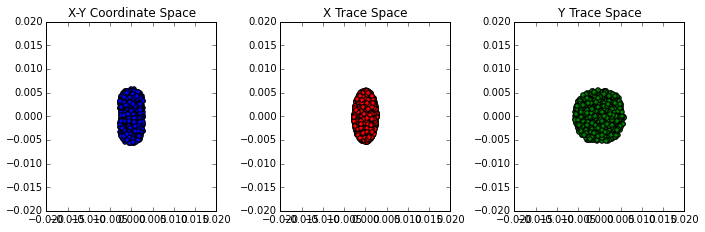

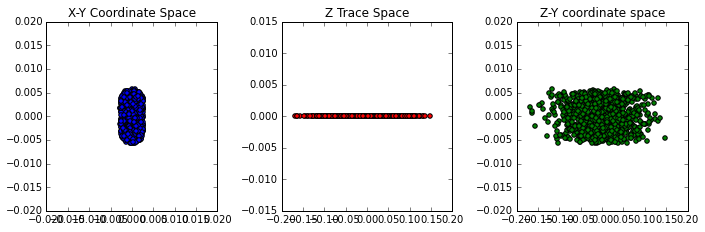

In [16]:
from base_diagnostics import pltbunch
pltbunch.plot_bunch(myBunch)
pltbunch.plot_long(myBunch)

In [17]:
# Define a bunch simulator
bunch_simulator = synergia.simulation.Bunch_simulator(myBunch)

# Define a set of bunch diagnostics

#basic diagnostics - PER STEP
basicdiag = synergia.bunch.Diagnostics_basic("basic.h5", opts.output_dir)
bunch_simulator.add_per_step(basicdiag)

#include full diagnostics
fulldiag = synergia.bunch.Diagnostics_full2("full.h5", opts.output_dir)
bunch_simulator.add_per_turn(fulldiag)

#tracking diagnostics - PER STEP
diagnostics = synergia.bunch.Diagnostics_track("track.h5", opts.tracked_particles, opts.output_dir)
#Track a particle twice per turn (e.g. every ~ num_steps/2 add the diagnostic)
bunch_simulator.add_per_step(diagnostics)

#particle diagnostics - PER TURN
particlediag = synergia.bunch.Diagnostics_particles("particles.h5",0,0,opts.output_dir)
bunch_simulator.add_per_turn(particlediag)

In [19]:
#~0.3s5 per turn with 1000 macro particles and full chef only in the NL magnet (40 slices rather than 20)
opts.turns = 100
propagator = synergia.simulation.Propagator(stepper)
propagator.set_checkpoint_period(opts.checkpointperiod)
propagator.propagate(bunch_simulator,opts.turns, opts.maxturns,opts.verbosity)

#clean up files
workflow.cleanup(opts.output_dir)

###Diagnostics

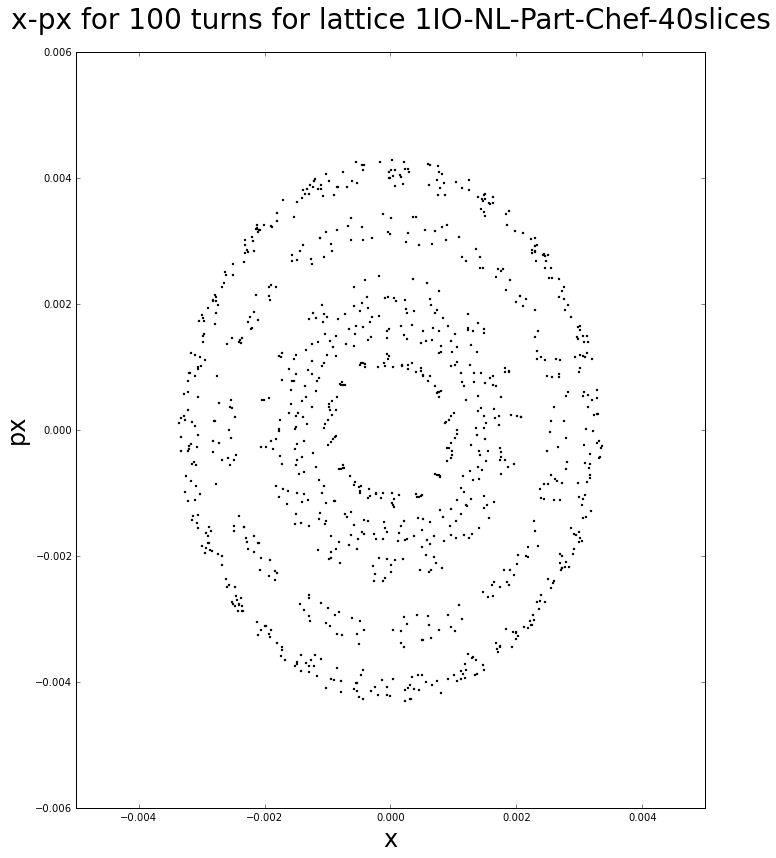

In [66]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = '1IO-NL-Part-Chef-40slices'
popts.path = None
popts.turns = 100 
popts.norm = False
popts.save = False
popts.variance = 0.5
popts.lattice_simulator = lattice_simulator2
popts.relpath = opts.output_dir
popts.lf_fns = ['beta_x','beta_y']
popts.lattice = lattice2

popts.plots = ['x','px']
popts.num = 10
popts.scale = 2
popts.plot_lost = False

singleparticle.plot_Poincare(popts)

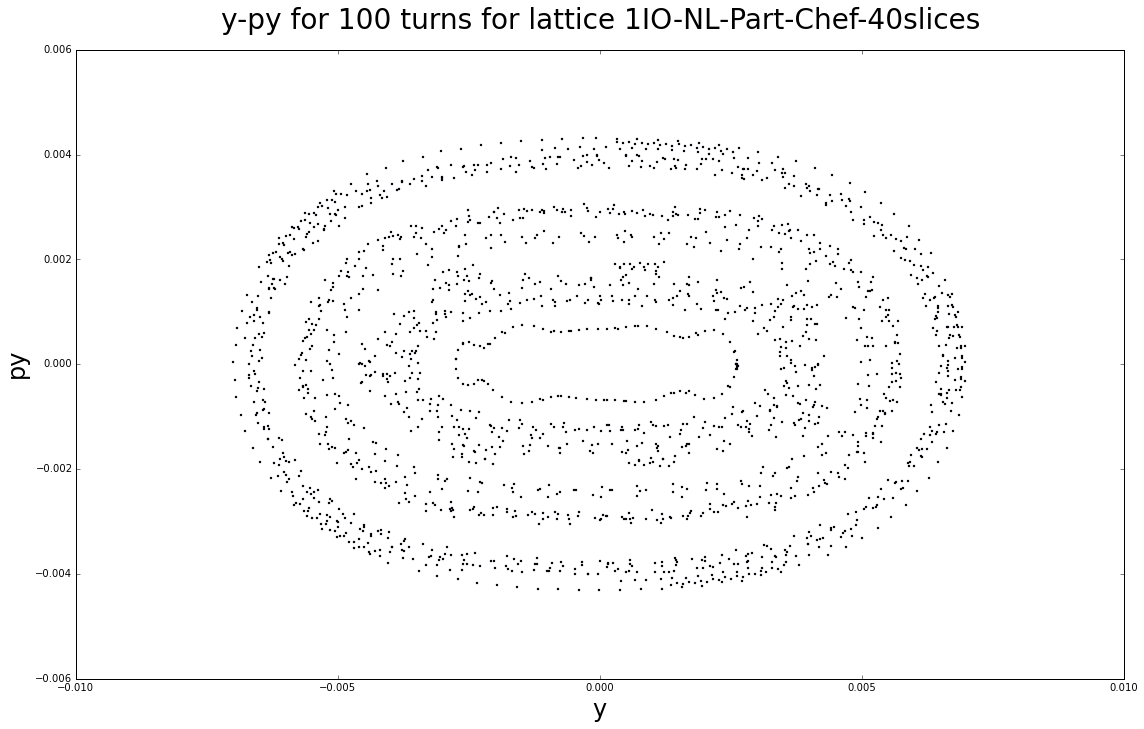

In [22]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = '1IO-NL-Part-Chef-40slices'
popts.ID = None
popts.path = None
popts.turns = 100 
popts.norm = False
popts.save = False
popts.variance = 0.5
popts.lattice_simulator = lattice_simulator2
popts.relpath = opts.output_dir
popts.lf_fns = ['beta_x','beta_y']
popts.lattice = lattice2

popts.plots = ['y','py']
popts.num = 20
popts.scale = 2
popts.plot_lost = False

singleparticle.plot_Poincare(popts)

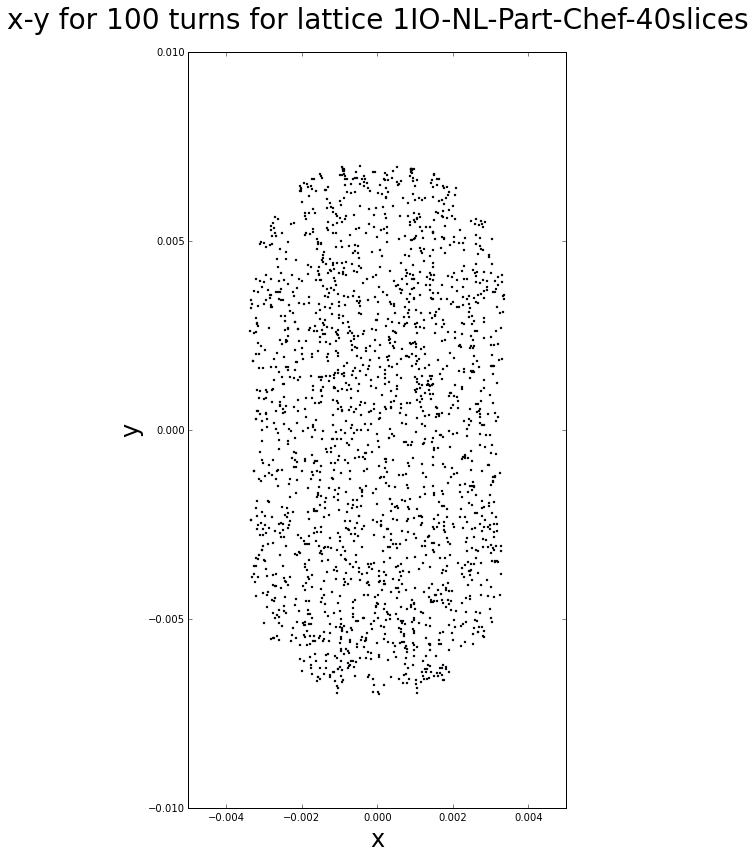

In [65]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = '1IO-NL-Part-Chef-40slices'
popts.ID = None
popts.path = None
popts.turns = 100 
popts.norm = False
popts.save = False
popts.variance = 0.5
popts.lattice_simulator = lattice_simulator2
popts.relpath = opts.output_dir
popts.lf_fns = ['beta_x','beta_y']
popts.lattice = lattice2

popts.plots = ['x','y']
popts.num = 20
popts.scale = 2
popts.plot_lost = False

singleparticle.plot_Poincare(popts)

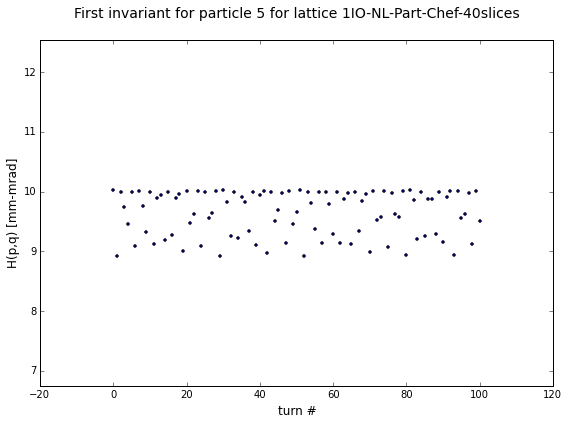

In [39]:
#popts.lattice_simulator = stepper.get_lattice_simulator()
popts.num = 1
popts.ID = 5
popts.variance = .3
popts.save = False
singleparticle.plot_elliptic_Invariant(popts)
#singleparticle.plot_H_I(popts)

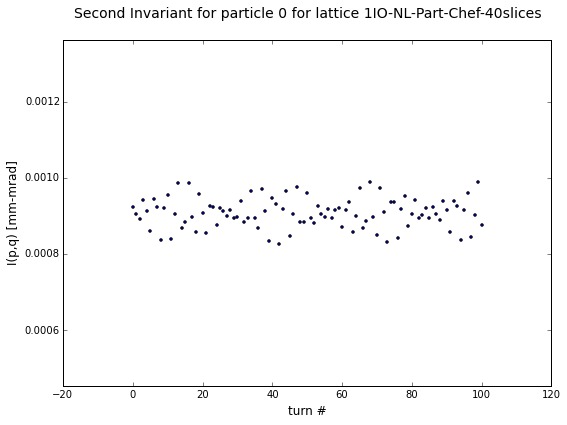

In [28]:
#popts.lattice_simulator = stepper.get_lattice_simulator()
popts.num = 2
popts.ID = 0
popts.variance = .5
popts.save = False
singleparticle.plot_elliptic_Invariant(popts)
#singleparticle.plot_H_I(popts)

In [31]:
from elliptic import spi
popts.macro_particles = opts.macro_particles
hArray = singleparticle.calc_elliptic_Invariant(popts)
popts.printfile = 'stats.txt'
spi.print_stats(hArray,popts)

Summary of invariants for 1000 particles with lattice 1IO-NL-Part-Chef-40slices
H [mm-mrad]: 9.87924941486
H_std [%]: 2.41701747827
I [mm-mrad]: 0.00175699028211
I_std [%]: 3.10603726772


Clearly increasing the number of slices has not reduced the spread in the invariant. We are still seeing $2.5 \%$ variation in H and $3 \%$ variation in I. One consideration here is the effect of the individual particle coordinates on the perturbation of the invariants, but that analysis is ongoing and secondary to the effect of the tune spread.

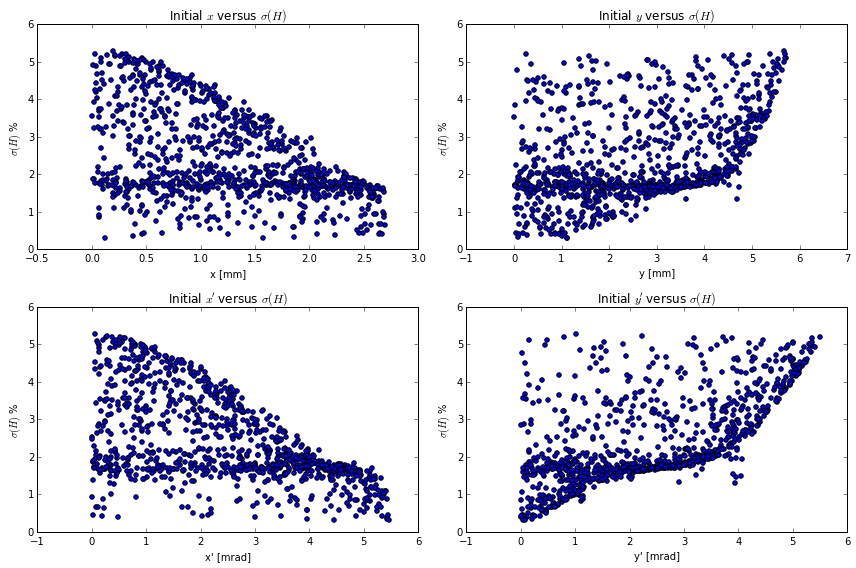

In [63]:
popts.num = 1
spi.plot_amplitudes(hArray,original_particles,popts)

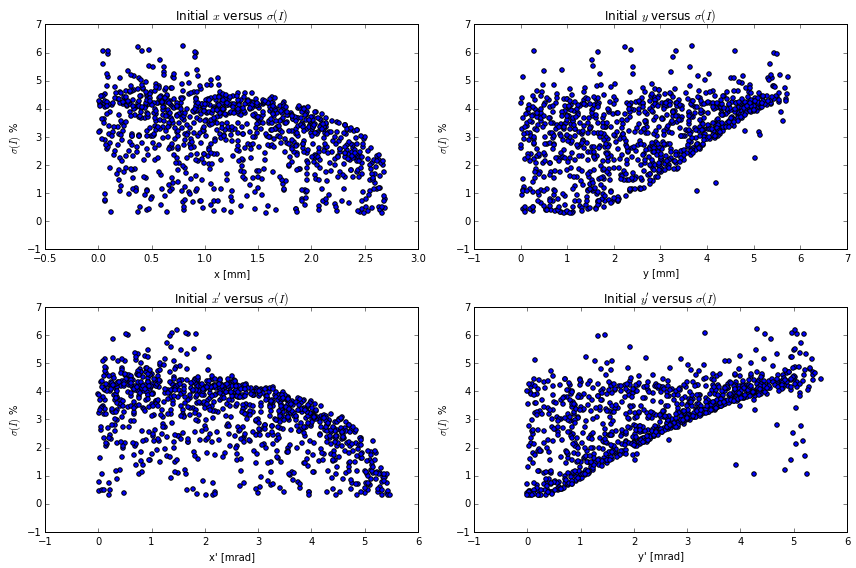

In [69]:
popts.macro_particles = opts.macro_particles
popts.num = 2
spi.plot_amplitudes(hArray,original_particles,popts)

**Stephen's point:** The invariant has a higher order term proportional to $\nu^3$ which introduces error in the invariant. If the tune through the nonlinear magnet is $\nu = 0.3$, then the error in the invariant is off the order $0.3^3 \approx 3 \%$, which is what is being observed.

**Follow Up** Thus, if we design a nonlinear segment with larger tune, then we should see a significant increase in the fluctuation of the invariant. I will implement this approach in part 3.